In [66]:
import pickle
from gensim.models import word2vec, Word2Vec
import multiprocessing
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
import pickle
import requests
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from scipy.spatial.distance import cosine
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from chembl_webresource_client.new_client import new_client
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Reshape, GRU, SpatialDropout1D, LSTM, Dropout
from keras.layers import BatchNormalization, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KDTree
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import ClusterCentroids

%matplotlib inline

## Load ATC data

In [67]:
with open("../skipgram/data/mol_sentences.pkl", "rb") as file:
    sentences = pickle.load(file)

In [68]:
atc = [sentence[1][0] for sentence in sentences]
sentences = [sentence[3] for sentence in sentences]

In [69]:
s_arr = []
for s in sentences:
    s_arr+=s
s_arr = np.unique(np.asarray(s_arr))

def my_encoder(s_arr, s):
    os = np.zeros(s_arr.shape[0])
    x = Counter(s)
    for a in range(len(s_arr)):
        if s_arr[a] in s:
            os[a]+=x[s_arr[a]]
    return os
            

In [70]:
data = [my_encoder(s_arr, s) for s in sentences]

In [76]:
X = data

X = np.asarray(X)
X.shape

le = LabelEncoder()
le.fit(atc)

atc = le.transform(atc)
y = atc

In [82]:
def balance(X, y):    
    cc = ClusterCentroids(random_state=0)
    X_resampled, y_resampled = cc.fit_resample(X, y)
    return X_resampled, y_resampled

atc_counter = Counter(y)
top_atc = [a for a, _ in atc_counter.most_common(4)]
# top_atc = [2,6,9]

temp_x = []
temp_y = []

for i in range(y.shape[0]):
    if y[i] in top_atc:
        temp_x.append(X[i])
        temp_y.append(y[i])
        
X = np.asarray(temp_x)
y = np.asarray(temp_y)

atc_labels = le.inverse_transform(np.unique(y))

# X, y = balance(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=int(random.random()*100))

def accuracy(y_true, y_pred, atc_labels=atc_labels):
    print("Overall Accuracy:", np.sum(np.equal(y_true, y_pred))/y_true.shape[0])
    matrix = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix, annot=True,cbar=False, xticklabels=atc_labels, yticklabels=atc_labels)

/home/kavya/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Overall Accuracy: 0.6023529411764705
             precision    recall  f1-score   support

          0       0.45      0.44      0.45        91
          2       0.54      0.46      0.50       100
          6       0.80      0.71      0.76        91
          9       0.61      0.73      0.67       143

avg / total       0.60      0.60      0.60       425



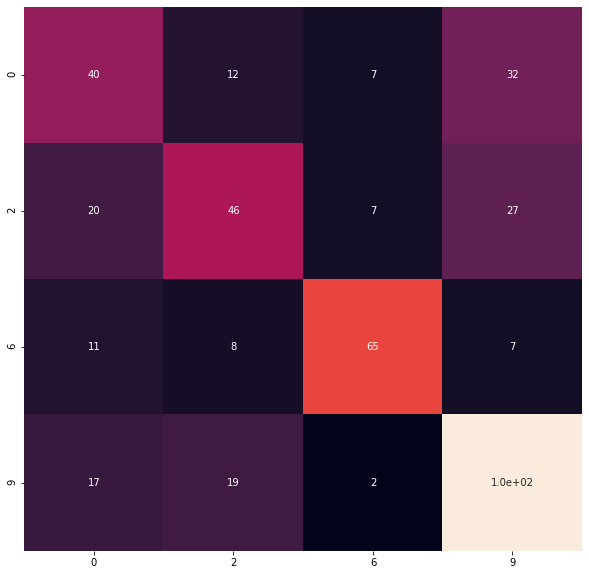

In [83]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
accuracy(y_test, model.predict(X_test))

Overall Accuracy: 0.6776470588235294
             precision    recall  f1-score   support

          0       0.57      0.49      0.53        91
          2       0.73      0.51      0.60       100
          6       0.89      0.82      0.86        91
          9       0.61      0.82      0.70       143

avg / total       0.69      0.68      0.67       425



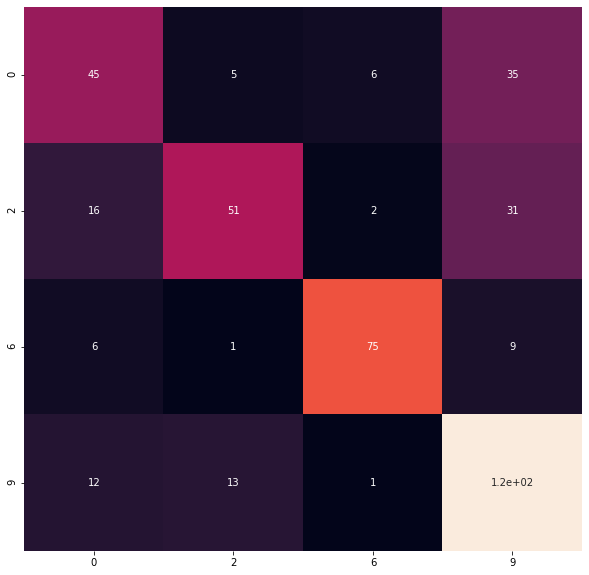

In [84]:
rf_model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt', criterion='entropy')
# Fit on training data
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy(y_test, y_pred, atc_labels)

Overall Accuracy: 0.6823529411764706
             precision    recall  f1-score   support

          0       0.58      0.54      0.56        91
          2       0.72      0.53      0.61       100
          6       0.89      0.78      0.83        91
          9       0.63      0.82      0.71       143

avg / total       0.69      0.68      0.68       425



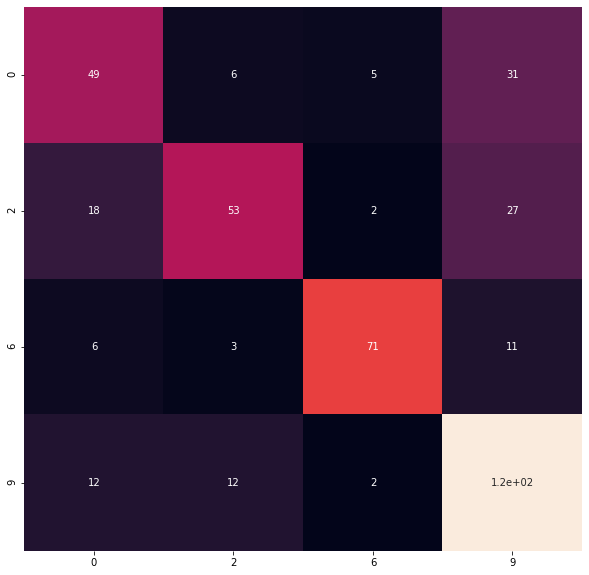

In [85]:
xt_model = ExtraTreesClassifier(n_estimators=100, warm_start=True,
                                max_features = 'sqrt', criterion='entropy', random_state=98)
    # Fit on training data
xt_model.fit(X_train, y_train)

y_pred = xt_model.predict(X_test)
accuracy(y_test, y_pred, atc_labels)